## Time series analyse

## We choose a window of 60 time steps
## We want to learn 48 steps and predict 12 steps.
## Each step = 1 second

In [2]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence, split_sequence_long
import math

%load_ext autoreload
%autoreload 2

2024-04-28 05:41:56.759225: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 05:41:56.783444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 05:41:56.783463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 05:41:56.784103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 05:41:56.788172: I tensorflow/core/platform/cpu_feature_guar

### Data Exploration

In [3]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [4]:
# show head
print(data.shape)
data.head()

(4597200, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [5]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [6]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [7]:
temp_data = data

In [8]:
temp_data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Date Time
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,2009-01-01 00:00:00
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,2009-01-01 00:00:01
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2009-01-01 00:00:02
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,2009-01-01 00:00:03
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,2009-01-01 00:00:04


In [9]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [11]:
data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545


### Windowing
We choose a window of 60 time steps
We want to learn 48 steps and predict 12 steps.

In [12]:
window_size = 60
grouped_data = windowing_array(data, window_size)

In [13]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

76620
60
8


### Slice and Split sequence 

In [14]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [15]:
x_train_init.shape, x_test_init.shape

((61296, 60, 8), (15324, 60, 8))

In [16]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [17]:
x_train.shape, y_train.shape

((61296, 48, 8), (61296, 12, 8))

In [18]:
x_train.shape[0], x_train.shape[1], x_train.shape[2]

(61296, 48, 8)

In [19]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [20]:
y_train.shape

(61296, 12, 2)

In [21]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [22]:
x_test.shape, y_test.shape

((15324, 48, 8), (15324, 12, 8))

In [23]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [24]:
y_test.shape

(15324, 12, 2)

In [25]:
y = x_test[100]
y.shape

(48, 8)

In [26]:
y

array([[-1.74380478e+02,  1.38778503e+02,  3.63910682e-02,
         2.03316423e+00,  2.84788703e+01,  0.00000000e+00,
        -1.13481336e-08,  1.00000000e+00],
       [-1.75081146e+02,  1.38408676e+02,  3.63602452e-02,
         2.05624878e+00,  2.85647474e+01,  0.00000000e+00,
         1.04528455e-01,  9.94521896e-01],
       [-1.75768967e+02,  1.38016068e+02,  3.64127718e-02,
         2.08465912e+00,  2.84874103e+01,  0.00000000e+00,
         2.07911685e-01,  9.78147602e-01],
       [-1.76443207e+02,  1.37602615e+02,  3.64324562e-02,
         2.11607270e+00,  2.84873952e+01,  0.00000000e+00,
         3.09016978e-01,  9.51056522e-01],
       [-1.77110443e+02,  1.37177582e+02,  3.64315026e-02,
         2.13818653e+00,  2.84843674e+01,  0.00000000e+00,
         4.06736630e-01,  9.13545464e-01],
       [-1.77772598e+02,  1.36744934e+02,  3.64316925e-02,
         2.15155772e+00,  2.84697138e+01,  0.00000000e+00,
         4.99999990e-01,  8.66025410e-01],
       [-1.78419937e+02,  1.362947

In [54]:
pos_x = y[:, :1]
pos_x

array([[-174.38047791],
       [-175.08114624],
       [-175.76896667],
       [-176.44320679],
       [-177.11044312],
       [-177.77259827],
       [-178.41993713],
       [-179.05128479],
       [-179.67544556],
       [-180.28320312],
       [-180.87503052],
       [-181.45974731],
       [-182.02653503],
       [-182.5753479 ],
       [-183.11480713],
       [-183.64749146],
       [-184.16136169],
       [-184.65472412],
       [-185.13790894],
       [-185.59977722],
       [-186.04116821],
       [-186.47267151],
       [-186.88215637],
       [-187.27018738],
       [-187.64678955],
       [-188.01528931],
       [-188.36224365],
       [-188.68571472],
       [-188.99693298],
       [-189.28356934],
       [-189.54660034],
       [-189.79745483],
       [-190.02349854],
       [-190.22567749],
       [-190.41499329],
       [-190.5791626 ],
       [-190.71969604],
       [-190.8474884 ],
       [-190.9667511 ],
       [-191.0637207 ],
       [-191.13717651],
       [-191.198

In [56]:
pos_y = y[:, 1:2]
pos_y

array([[138.77850342],
       [138.40867615],
       [138.0160675 ],
       [137.60261536],
       [137.17758179],
       [136.74493408],
       [136.29478455],
       [135.82575989],
       [135.34519958],
       [134.84410095],
       [134.3230896 ],
       [133.78970337],
       [133.23712158],
       [132.66734314],
       [132.0877533 ],
       [131.50190735],
       [130.90296936],
       [130.2901001 ],
       [129.66821289],
       [129.03086853],
       [128.37840271],
       [127.7155838 ],
       [127.03839874],
       [126.34877014],
       [125.65172577],
       [124.95027161],
       [124.24098969],
       [123.52364349],
       [122.80041504],
       [122.06781006],
       [121.325737  ],
       [120.57603455],
       [119.81773376],
       [119.05251312],
       [118.28283691],
       [117.50924683],
       [116.73299408],
       [115.95448303],
       [115.17407227],
       [114.39187622],
       [113.60775757],
       [112.82059479],
       [112.03066254],
       [111

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pos(pos_x, pos_y):

    # Convert 2D arrays to 1D arrays
    pos_x = np.squeeze(pos_x)
    pos_y = np.squeeze(pos_y)

    # Print original arrays
    print("Original pos.x:", pos_x)
    print("Original pos.y:", pos_y)
    
    # Plot original pos.x and pos.y
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(pos_x, pos_y, label='(pos.x, pos.y)')
    plt.title('Original pos.x')
    plt.legend()
    
    # Shuffle pos.x
    pos_x_shuffled = np.random.permutation(pos_x)
    
    # Print shuffled pos.x
    print("Shuffled pos.x:", pos_x_shuffled)
    
    # Plot shuffled pos.x and pos.y
    plt.subplot(2, 1, 2)
    plt.plot(pos_x_shuffled, pos_y, label='(pos.x, pos.y)')
    plt.title('Shuffled pos.x')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Original pos.x: [-174.38047791 -175.08114624 -175.76896667 -176.44320679 -177.11044312
 -177.77259827 -178.41993713 -179.05128479 -179.67544556 -180.28320312
 -180.87503052 -181.45974731 -182.02653503 -182.5753479  -183.11480713
 -183.64749146 -184.16136169 -184.65472412 -185.13790894 -185.59977722
 -186.04116821 -186.47267151 -186.88215637 -187.27018738 -187.64678955
 -188.01528931 -188.36224365 -188.68571472 -188.99693298 -189.28356934
 -189.54660034 -189.79745483 -190.02349854 -190.22567749 -190.41499329
 -190.5791626  -190.71969604 -190.8474884  -190.9667511  -191.0637207
 -191.13717651 -191.19862366 -191.25216675 -191.30056763 -191.34565735
 -191.37962341 -191.4041748  -191.42428589]
Original pos.y: [138.77850342 138.40867615 138.0160675  137.60261536 137.17758179
 136.74493408 136.29478455 135.82575989 135.34519958 134.84410095
 134.3230896  133.78970337 133.23712158 132.66734314 132.0877533
 131.50190735 130.90296936 130.2901001  129.66821289 129.03086853
 128.37840271 127.71558

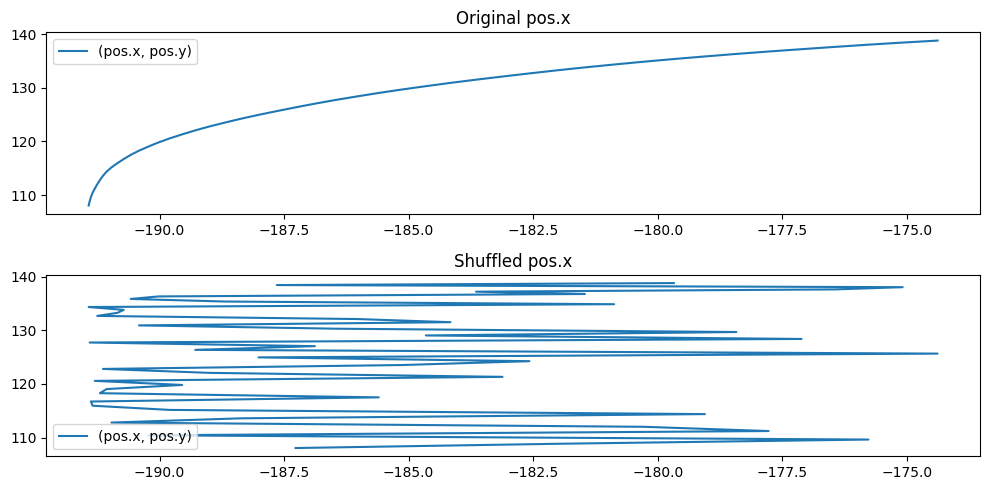

In [59]:
plot_pos(pos_x, pos_y)

## Display correlation

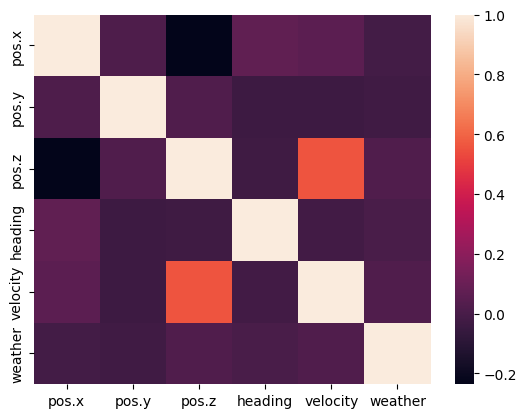

In [61]:
# import modules 
import matplotlib.pyplot as mp 
import pandas as pd 
import seaborn as sb 


# plotting correlation heatmap 
dataplot=sb.heatmap(csv_input.corr()) 

# displaying heatmap 
mp.show()

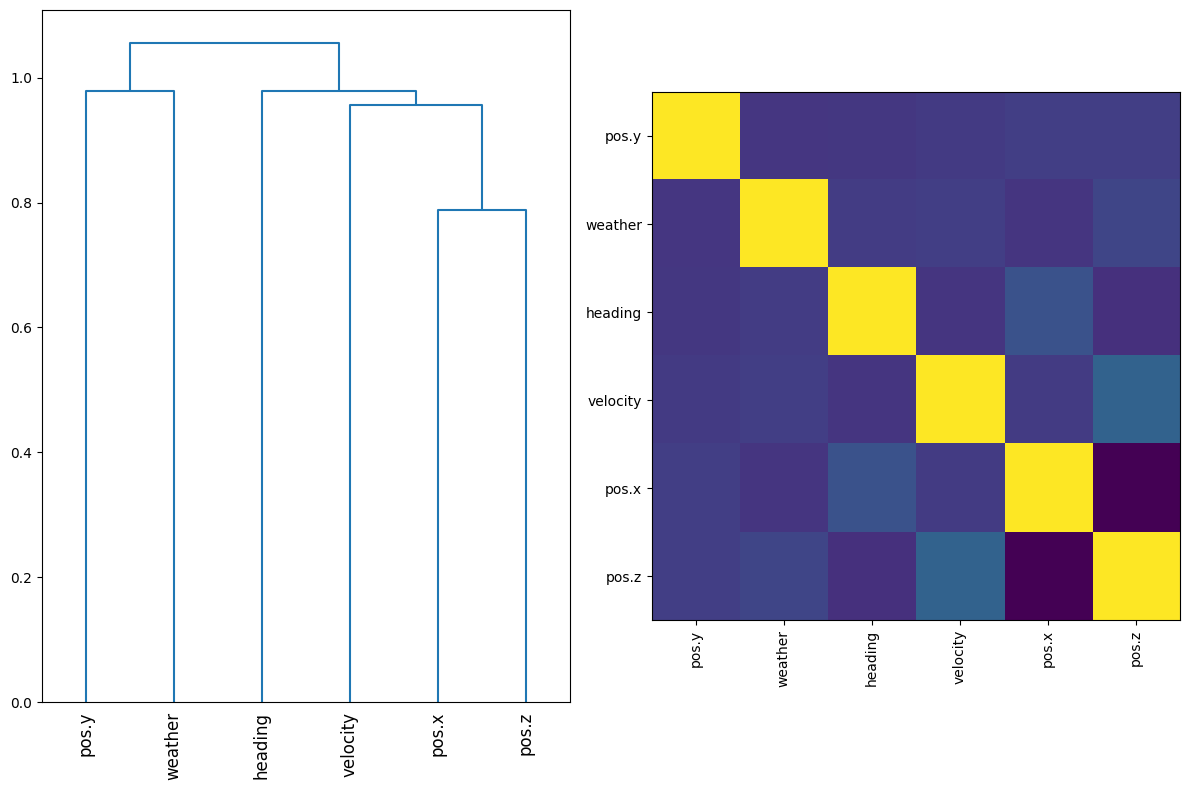

In [62]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(csv_input).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=csv_input.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [63]:
import numpy as np
from scipy.stats import pearsonr

def generate_perturbations(time_series_matrix):
    # Step 1: Compute correlation matrix
    correlation_matrix = np.corrcoef(np.transpose(time_series_matrix))
    num_features = len(correlation_matrix)

    # Step 2: Identify feature pairs with significant correlation coefficients
    correlated_features = {}
    for i in range(num_features):
        for j in range(i + 1, num_features):
            correlation = correlation_matrix[i, j]
            if abs(correlation) > 0.5:  # Adjust threshold as needed
                correlated_features[(i, j)] = correlation

    # Step 3: Generate perturbation values
    perturbation_values = {}
    for feature_pair, correlation in correlated_features.items():
        feature1, feature2 = feature_pair
        perturbation_values[feature1] = np.random.normal(0, abs(correlation), size=len(time_series_matrix))
        perturbation_values[feature2] = np.random.normal(0, abs(correlation), size=len(time_series_matrix))

    # Step 4: Ensure perturbation values do not result in unrealistic data
    for feature_index in range(num_features):
        mean = np.mean(time_series_matrix[:, feature_index])
        std = np.std(time_series_matrix[:, feature_index])
        perturbation_values[feature_index] = np.clip(perturbation_values[feature_index], mean - 2 * std, mean + 2 * std)

    return perturbation_values

# Example usage
time_series_matrix = np.array([[-1.74, 1.23, 3.5], [23.3, 4.5, 1.2], [3.4, 1.2, 4.4]])
perturbation_values = generate_perturbations(time_series_matrix)
print("Perturbation values:")
print(perturbation_values)


Perturbation values:
{0: array([0.77938837, 0.3847716 , 0.76979168]), 1: array([-0.46412877,  0.49393656, -0.78722456]), 2: array([0.33848228, 0.55701559, 0.33848228])}


In [68]:
import numpy as np

def perturb_time_series(matrix):
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(matrix, rowvar=False)
    
    # Initialize perturbation matrix
    perturbed_matrix = np.copy(matrix)
    
    # Iterate over each feature
    for i in range(matrix.shape[1]):
        # Find indices of features with high correlation with feature i
        correlated_features = np.where((np.abs(corr_matrix[i]) > 0.7) & (np.abs(corr_matrix[i]) < 1.0))[0]
        
        # Compute perturbation values based on correlation grade
        for j in correlated_features:
            if i != j:
                perturbation_factor = corr_matrix[i, j]
                perturbed_matrix[:, j] += perturbation_factor * perturbed_matrix[:, i]
    
    return perturbed_matrix

# Example usage
time_series_matrix = np.array([[-1.74, 1.23, 3.5], [23.3, 4.5, 1.2], [3.4, 1.2, 4.4]])
perturbed_matrix = perturb_time_series(time_series_matrix)
print(perturbed_matrix)


[[ -7.10988488  -5.78420078   5.50708823]
 [ 90.93956025  71.57464239 -45.8970881 ]
 [ 10.50555629   7.41912047  -2.99644839]]


In [66]:
corr_matrix = np.corrcoef(time_series_matrix, rowvar=False)
corr_matrix

array([[ 1.        ,  0.97936939, -0.89077258],
       [ 0.97936939,  1.        , -0.9642297 ],
       [-0.89077258, -0.9642297 ,  1.        ]])

In [78]:
corr_matrix_2 = np.corrcoef(y, rowvar=False)
corr_matrix_2

/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[ 1.        ,  0.93449719, -0.02466257, -0.97094508,  0.04093063,
                nan,  0.62141107,  0.83997336],
       [ 0.93449719,  1.        ,  0.02579737, -0.99127599, -0.02395521,
                nan,  0.83895752,  0.61937884],
       [-0.02466257,  0.02579737,  1.        , -0.01846874, -0.86960932,
                nan,  0.10935382, -0.04962045],
       [-0.97094508, -0.99127599, -0.01846874,  1.        ,  0.01132747,
                nan, -0.78284027, -0.70985251],
       [ 0.04093063, -0.02395521, -0.86960932,  0.01132747,  1.        ,
                nan, -0.12224578,  0.08030885],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [ 0.62141107,  0.83895752,  0.10935382, -0.78284027, -0.12224578,
                nan,  1.        ,  0.25316634],
       [ 0.83997336,  0.61937884, -0.04962045, -0.70985251,  0.08030885,
                nan,  0.25316634,  1.        ]])

In [69]:
perturbed_matrix = perturb_time_series(y)

/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [71]:
y

array([[-1.74380478e+02,  1.38778503e+02,  3.63910682e-02,
         2.03316423e+00,  2.84788703e+01,  0.00000000e+00,
        -1.13481336e-08,  1.00000000e+00],
       [-1.75081146e+02,  1.38408676e+02,  3.63602452e-02,
         2.05624878e+00,  2.85647474e+01,  0.00000000e+00,
         1.04528455e-01,  9.94521896e-01],
       [-1.75768967e+02,  1.38016068e+02,  3.64127718e-02,
         2.08465912e+00,  2.84874103e+01,  0.00000000e+00,
         2.07911685e-01,  9.78147602e-01],
       [-1.76443207e+02,  1.37602615e+02,  3.64324562e-02,
         2.11607270e+00,  2.84873952e+01,  0.00000000e+00,
         3.09016978e-01,  9.51056522e-01],
       [-1.77110443e+02,  1.37177582e+02,  3.64315026e-02,
         2.13818653e+00,  2.84843674e+01,  0.00000000e+00,
         4.06736630e-01,  9.13545464e-01],
       [-1.77772598e+02,  1.36744934e+02,  3.64316925e-02,
         2.15155772e+00,  2.84697138e+01,  0.00000000e+00,
         4.99999990e-01,  8.66025410e-01],
       [-1.78419937e+02,  1.362947

In [70]:
perturbed_matrix

array([[-625.27043231, -363.08746454,  -24.70158039,  532.57656257,
          28.44722427,    0.        , -173.18658249, -284.12026143],
       [-630.1216569 , -367.57861709,  -24.77631403,  537.22810388,
          28.53312815,    0.        , -175.28739624, -285.93455867],
       [-634.97572616, -372.09491078,  -24.70896879,  541.89516926,
          28.45574546,    0.        , -177.40116021, -287.75146758],
       [-639.81996143, -376.62354423,  -24.70892109,  546.56443532,
          28.45571324,    0.        , -179.52239724, -289.56619483],
       [-644.64830254, -381.14529356,  -24.7062897 ,  551.2193684 ,
          28.4526862 ,    0.        , -181.64254978, -291.37757433],
       [-649.46208156, -385.65780721,  -24.6935465 ,  555.86081187,
          28.43803248,    0.        , -183.76108052, -293.18700324],
       [-654.2585988 , -390.17759352,  -24.57246408,  560.50228311,
          28.29885464,    0.        , -185.88646912, -294.99194505],
       [-659.03258973, -394.70278085,  -2

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pos(pos_x, pos_y, pos_x_shuffled):

    # Convert 2D arrays to 1D arrays
    pos_x = np.squeeze(pos_x)
    pos_y = np.squeeze(pos_y)

    # Print original arrays
    #print("Original pos.x:", pos_x)
    #print("Original pos.y:", pos_y)
    
    # Plot original pos.x and pos.y
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(pos_x, pos_y, label='(pos.x, pos.y)')
    plt.title('Original pos.x')
    plt.legend()

    
    # Print shuffled pos.x
    #print("Shuffled pos.x:", pos_x_shuffled)
    
    # Plot shuffled pos.x and pos.y
    plt.subplot(2, 1, 2)
    plt.plot(pos_x_shuffled, pos_y, label='(pos.x, pos.y)')
    plt.title('Shuffled pos.x')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [72]:
pos_x = y[:, :1]
pos_y = y[:, 1:2]
pos_x_shuffle = perturbed_matrix[:, :1]

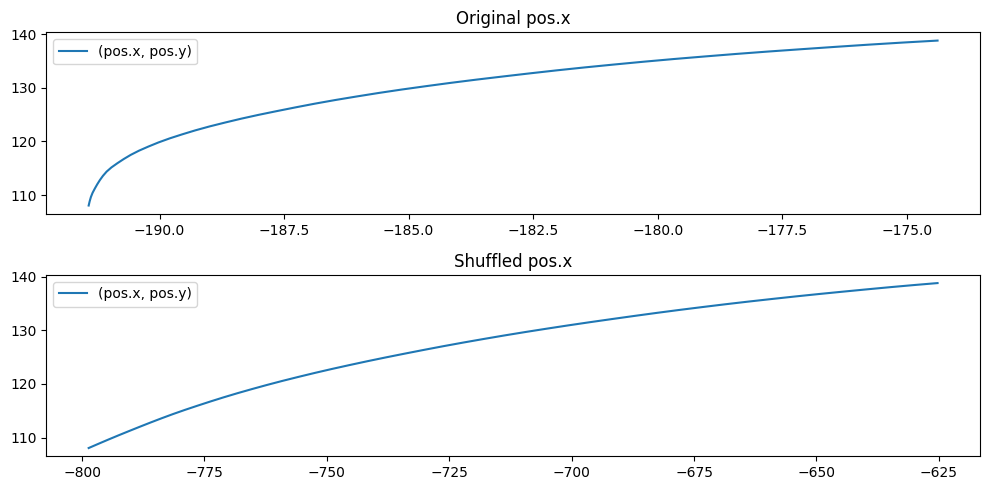

In [74]:
plot_pos(pos_x, pos_y, pos_x_shuffle)

In [75]:
import numpy as np

def perturb_time_series(matrix):
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(matrix, rowvar=False)
    
    # Initialize perturbation matrix
    perturbed_matrix = np.copy(matrix)
    
    # Iterate over each feature
    for i in range(matrix.shape[1]):
        # Find indices of features with high correlation with feature i
        correlated_features = np.where(np.abs(corr_matrix[i]) > 0.7)[0]
        
        # Compute perturbation values based on correlation grade
        for j in correlated_features:
            if i != j:
                perturbation_factor = corr_matrix[i, j]
                perturbed_matrix[:, j] += perturbation_factor * perturbed_matrix[:, i]
    
    # Add noise perturbation for features with low correlation
    for i in range(matrix.shape[1]):
        if np.abs(corr_matrix[i]).max() <= 0.7:
            perturbed_matrix[:, i] *= np.mean(perturbed_matrix[:, i])
    
    return perturbed_matrix


In [76]:
perturbed_matrix_2 = perturb_time_series(y)

/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [77]:
perturbed_matrix_2

array([[-625.27043231, -363.08746454,  -24.70158039,  532.57656257,
          28.44722427,    0.        , -173.18658249, -284.12026143],
       [-630.1216569 , -367.57861709,  -24.77631403,  537.22810388,
          28.53312815,    0.        , -175.28739624, -285.93455867],
       [-634.97572616, -372.09491078,  -24.70896879,  541.89516926,
          28.45574546,    0.        , -177.40116021, -287.75146758],
       [-639.81996143, -376.62354423,  -24.70892109,  546.56443532,
          28.45571324,    0.        , -179.52239724, -289.56619483],
       [-644.64830254, -381.14529356,  -24.7062897 ,  551.2193684 ,
          28.4526862 ,    0.        , -181.64254978, -291.37757433],
       [-649.46208156, -385.65780721,  -24.6935465 ,  555.86081187,
          28.43803248,    0.        , -183.76108052, -293.18700324],
       [-654.2585988 , -390.17759352,  -24.57246408,  560.50228311,
          28.29885464,    0.        , -185.88646912, -294.99194505],
       [-659.03258973, -394.70278085,  -2

In [30]:
corr_matrix_2 = np.corrcoef(y, rowvar=True)
corr_matrix_2

array([[1.        , 0.99999557, 0.99998288, ..., 0.99142333, 0.99104731,
        0.99066037],
       [0.99999557, 1.        , 0.99999576, ..., 0.99180227, 0.99143454,
        0.99105598],
       [0.99998288, 0.99999576, 1.        , ..., 0.99215573, 0.99179601,
        0.99142547],
       ...,
       [0.99142333, 0.99180227, 0.99215573, ..., 1.        , 0.99999581,
        0.99998316],
       [0.99104731, 0.99143454, 0.99179601, ..., 0.99999581, 1.        ,
        0.99999577],
       [0.99066037, 0.99105598, 0.99142547, ..., 0.99998316, 0.99999577,
        1.        ]])

In [31]:
corr_matrix_2 = np.corrcoef(y, rowvar=False)
corr_matrix_2

/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab000840/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[ 1.        ,  0.93449719, -0.02466257, -0.97094508,  0.04093063,
                nan,  0.62141107,  0.83997336],
       [ 0.93449719,  1.        ,  0.02579737, -0.99127599, -0.02395521,
                nan,  0.83895752,  0.61937884],
       [-0.02466257,  0.02579737,  1.        , -0.01846874, -0.86960932,
                nan,  0.10935382, -0.04962045],
       [-0.97094508, -0.99127599, -0.01846874,  1.        ,  0.01132747,
                nan, -0.78284027, -0.70985251],
       [ 0.04093063, -0.02395521, -0.86960932,  0.01132747,  1.        ,
                nan, -0.12224578,  0.08030885],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [ 0.62141107,  0.83895752,  0.10935382, -0.78284027, -0.12224578,
                nan,  1.        ,  0.25316634],
       [ 0.83997336,  0.61937884, -0.04962045, -0.70985251,  0.08030885,
                nan,  0.25316634,  1.        ]])

In [28]:
y_reshape = np.squeeze(y)
y_reshape

array([[-1.74380478e+02,  1.38778503e+02,  3.63910682e-02,
         2.03316423e+00,  2.84788703e+01,  0.00000000e+00,
        -1.13481336e-08,  1.00000000e+00],
       [-1.75081146e+02,  1.38408676e+02,  3.63602452e-02,
         2.05624878e+00,  2.85647474e+01,  0.00000000e+00,
         1.04528455e-01,  9.94521896e-01],
       [-1.75768967e+02,  1.38016068e+02,  3.64127718e-02,
         2.08465912e+00,  2.84874103e+01,  0.00000000e+00,
         2.07911685e-01,  9.78147602e-01],
       [-1.76443207e+02,  1.37602615e+02,  3.64324562e-02,
         2.11607270e+00,  2.84873952e+01,  0.00000000e+00,
         3.09016978e-01,  9.51056522e-01],
       [-1.77110443e+02,  1.37177582e+02,  3.64315026e-02,
         2.13818653e+00,  2.84843674e+01,  0.00000000e+00,
         4.06736630e-01,  9.13545464e-01],
       [-1.77772598e+02,  1.36744934e+02,  3.64316925e-02,
         2.15155772e+00,  2.84697138e+01,  0.00000000e+00,
         4.99999990e-01,  8.66025410e-01],
       [-1.78419937e+02,  1.362947

In [29]:
y

array([[-1.74380478e+02,  1.38778503e+02,  3.63910682e-02,
         2.03316423e+00,  2.84788703e+01,  0.00000000e+00,
        -1.13481336e-08,  1.00000000e+00],
       [-1.75081146e+02,  1.38408676e+02,  3.63602452e-02,
         2.05624878e+00,  2.85647474e+01,  0.00000000e+00,
         1.04528455e-01,  9.94521896e-01],
       [-1.75768967e+02,  1.38016068e+02,  3.64127718e-02,
         2.08465912e+00,  2.84874103e+01,  0.00000000e+00,
         2.07911685e-01,  9.78147602e-01],
       [-1.76443207e+02,  1.37602615e+02,  3.64324562e-02,
         2.11607270e+00,  2.84873952e+01,  0.00000000e+00,
         3.09016978e-01,  9.51056522e-01],
       [-1.77110443e+02,  1.37177582e+02,  3.64315026e-02,
         2.13818653e+00,  2.84843674e+01,  0.00000000e+00,
         4.06736630e-01,  9.13545464e-01],
       [-1.77772598e+02,  1.36744934e+02,  3.64316925e-02,
         2.15155772e+00,  2.84697138e+01,  0.00000000e+00,
         4.99999990e-01,  8.66025410e-01],
       [-1.78419937e+02,  1.362947

In [32]:
# Convert the 2D array to a DataFrame
df = pd.DataFrame(y)
df

,0,1,2,3,4,5,6,7
0,-174.380478,138.778503,0.036391,2.033164,28.478870,0.0,-1.134813e-08,1.000000e+00
1,-175.081146,138.408676,0.036360,2.056249,28.564747,0.0,1.045285e-01,9.945219e-01
2,-175.768967,138.016068,0.036413,2.084659,28.487410,0.0,2.079117e-01,9.781476e-01
3,-176.443207,137.602615,0.036432,2.116073,28.487395,0.0,3.090170e-01,9.510565e-01
4,-177.110443,137.177582,0.036432,2.138187,28.484367,0.0,4.067366e-01,9.135455e-01
5,-177.772598,136.744934,0.036432,2.151558,28.469714,0.0,5.000000e-01,8.660254e-01
6,-178.419937,136.294785,0.036484,2.173535,28.330581,0.0,5.877852e-01,8.090170e-01
7,-179.051285,135.825760,0.036478,2.203076,28.332610,0.0,6.691306e-01,7.431448e-01
8,-179.675446,135.345200,0.036429,2.225500,28.394283,0.0,7.431448e-01,6.691306e-01
9,-180.283203,134.844101,0.036439,2.254350,28.351957,0.0,8.090170e-01,5.877853e-01


In [34]:

corr_matrix = df.corr()
corr_matrix

,0,1,2,3,4,5,6,7
0,1.000000,0.934497,-0.024663,-0.970945,0.040931,NaN,0.621411,0.839973
1,0.934497,1.000000,0.025797,-0.991276,-0.023955,NaN,0.838958,0.619379
2,-0.024663,0.025797,1.000000,-0.018469,-0.869609,NaN,0.109354,-0.049620
3,-0.970945,-0.991276,-0.018469,1.000000,0.011327,NaN,-0.782840,-0.709853
4,0.040931,-0.023955,-0.869609,0.011327,1.000000,NaN,-0.122246,0.080309
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.621411,0.838958,0.109354,-0.782840,-0.122246,NaN,1.000000,0.253166
7,0.839973,0.619379,-0.049620,-0.709853,0.080309,NaN,0.253166,1.000000


In [35]:
# Convert DataFrame to NumPy array
corr_matrix_np = df.corr().values

# Replace NaN values with 0
corr_matrix_np = np.nan_to_num(corr_matrix_np, nan=0)
corr_matrix_np

array([[ 1.        ,  0.93449719, -0.02466257, -0.97094508,  0.04093063,
         0.        ,  0.62141107,  0.83997336],
       [ 0.93449719,  1.        ,  0.02579737, -0.99127599, -0.02395521,
         0.        ,  0.83895752,  0.61937884],
       [-0.02466257,  0.02579737,  1.        , -0.01846874, -0.86960932,
         0.        ,  0.10935382, -0.04962045],
       [-0.97094508, -0.99127599, -0.01846874,  1.        ,  0.01132747,
         0.        , -0.78284027, -0.70985251],
       [ 0.04093063, -0.02395521, -0.86960932,  0.01132747,  1.        ,
         0.        , -0.12224578,  0.08030885],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.62141107,  0.83895752,  0.10935382, -0.78284027, -0.12224578,
         0.        ,  1.        ,  0.25316634],
       [ 0.83997336,  0.61937884, -0.04962045, -0.70985251,  0.08030885,
         0.        ,  0.25316634,  1.        ]])

In [36]:
# Convert the 2D array to a DataFrame
df = pd.DataFrame(y)
#compute the correlation DataFrame
corr_DataFrame = df.corr()
# Convert DataFrame to NumPy array
corr_matrix = corr_DataFrame.values
# Replace NaN values with 0
corr_matrix = np.nan_to_num(corr_matrix, nan=0)
corr_matrix

array([[ 1.        ,  0.93449719, -0.02466257, -0.97094508,  0.04093063,
         0.        ,  0.62141107,  0.83997336],
       [ 0.93449719,  1.        ,  0.02579737, -0.99127599, -0.02395521,
         0.        ,  0.83895752,  0.61937884],
       [-0.02466257,  0.02579737,  1.        , -0.01846874, -0.86960932,
         0.        ,  0.10935382, -0.04962045],
       [-0.97094508, -0.99127599, -0.01846874,  1.        ,  0.01132747,
         0.        , -0.78284027, -0.70985251],
       [ 0.04093063, -0.02395521, -0.86960932,  0.01132747,  1.        ,
         0.        , -0.12224578,  0.08030885],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.62141107,  0.83895752,  0.10935382, -0.78284027, -0.12224578,
         0.        ,  1.        ,  0.25316634],
       [ 0.83997336,  0.61937884, -0.04962045, -0.70985251,  0.08030885,
         0.        ,  0.25316634,  1.        ]])

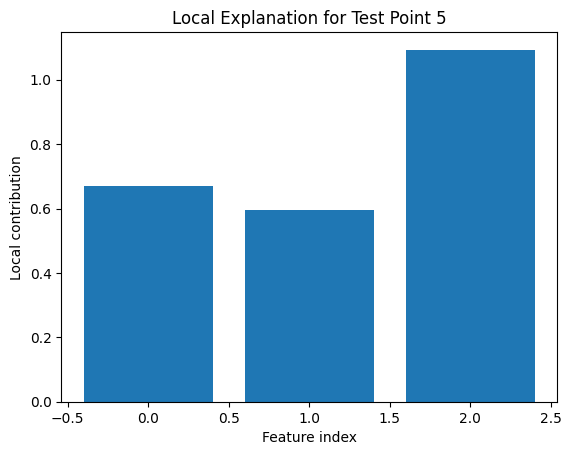

In [37]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Simulate multivariate time series data
np.random.seed(42)
time_steps = 100
features = 3

# Create random data
data = np.random.rand(time_steps, features)

# Simulate future values (simple sum of features for demonstration)
target = data.sum(axis=1) + np.random.rand(time_steps) * 0.5

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Select a point to explain
test_index = 5
x_explain = X_test[test_index]

# Generate local perturbations
num_perturb = 50
perturbed_data = np.tile(x_explain, (num_perturb, 1)) + np.random.randn(num_perturb, features) * 0.1
perturbed_data = np.clip(perturbed_data, 0, 1)  # Assuming all features are normalized between 0 and 1

# Get model predictions for these perturbations
predictions = model.predict(perturbed_data)

# Use proximity weighting, simple exponential decay based on euclidean distance
weights = np.exp(-np.sqrt(((perturbed_data - x_explain)**2).sum(axis=1)))

# Train a local linear model
local_model = LinearRegression()
local_model.fit(perturbed_data, predictions, sample_weight=weights)

# Get the local explanation
coefficients = local_model.coef_

# Plotting the explanation
plt.bar(range(features), coefficients)
plt.title('Local Explanation for Test Point {}'.format(test_index))
plt.xlabel('Feature index')
plt.ylabel('Local contribution')
plt.show()


In [40]:
weights.shape

(50,)

In [41]:
data.shape

(100, 3)

In [43]:
target.shape

(100,)

In [44]:
y_train.shape

(80,)

In [46]:
X_train.shape

(80, 3)

In [47]:
x_explain.shape

(3,)

In [48]:
x_explain

array([0.18657006, 0.892559  , 0.53934224])

In [49]:
perturbed_data.shape

(50, 3)

In [50]:
predictions.shape

(50,)

In [51]:
coefficients

array([0.67040976, 0.59516895, 1.09324113])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Coefficients DataFrame:
        Feature_0  Feature_1  Feature_2
const   0.190684   0.880228   0.543381


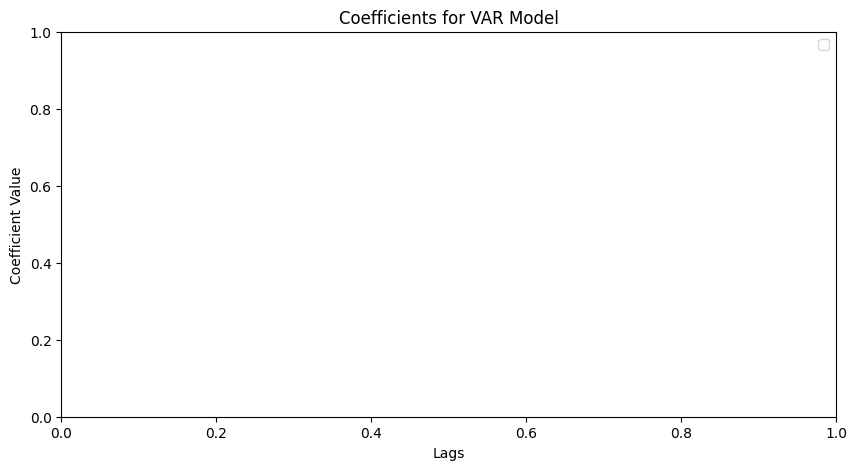

In [56]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR

# Simulate multivariate time series data
np.random.seed(42)
time_steps = 100
features = 3

# Create random data
data = np.random.rand(time_steps, features)

# Simulate future values (simple sum of features for demonstration)
target = data.sum(axis=1) + np.random.rand(time_steps) * 0.5

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Select a point to explain
test_index = 5
x_explain = X_test[test_index]

# Generate local perturbations
num_perturb = 50
perturbed_data = np.tile(x_explain, (num_perturb, 1)) + np.random.randn(num_perturb, features) * 0.1
perturbed_data = np.clip(perturbed_data, 0, 1)  # Assuming all features are normalized between 0 and 1

# Get model predictions for these perturbations
predictions = model.predict(perturbed_data)

# Use proximity weighting, simple exponential decay based on Euclidean distance
weights = np.exp(-np.sqrt(((perturbed_data - x_explain)**2).sum(axis=1)))

# Format data for VAR - needs to be in DataFrame format with time series structure
df_perturbed = pd.DataFrame(data=perturbed_data, columns=['Feature_{}'.format(i) for i in range(features)])
var_model = VAR(df_perturbed)

# Fit the VAR model and choose optimal lags based on AIC
results = var_model.fit(ic='aic')

# Accessing the coefficients properly
coefficients = results.params
print("Coefficients DataFrame:\n", coefficients)

# Plotting each coefficient
plt.figure(figsize=(10, 5))

# Assuming you want to plot coefficients for a specific response (e.g., 'Feature_0')
# Loop through each lag and plot its coefficient
for col in coefficients.columns:
    if 'L1' in col:  # Example: Adjust to select the correct lag variables
        plt.plot(coefficients.index, coefficients[col], label=col)

plt.title('Coefficients for VAR Model')
plt.xlabel('Lags')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()


In [55]:
df_perturbed

,Feature_0,Feature_1,Feature_2
0,0.317118,0.894659,0.607538
1,0.155543,0.924976,0.526328
2,0.196270,0.952075,0.457520
3,0.395809,0.791957,0.417923
4,0.302381,0.971725,0.601754
5,0.249405,0.891334,0.449617
6,0.194151,0.824843,0.636854
7,0.171864,0.810009,0.507204
8,0.227863,0.836187,0.457120
9,0.210939,0.917056,0.488648


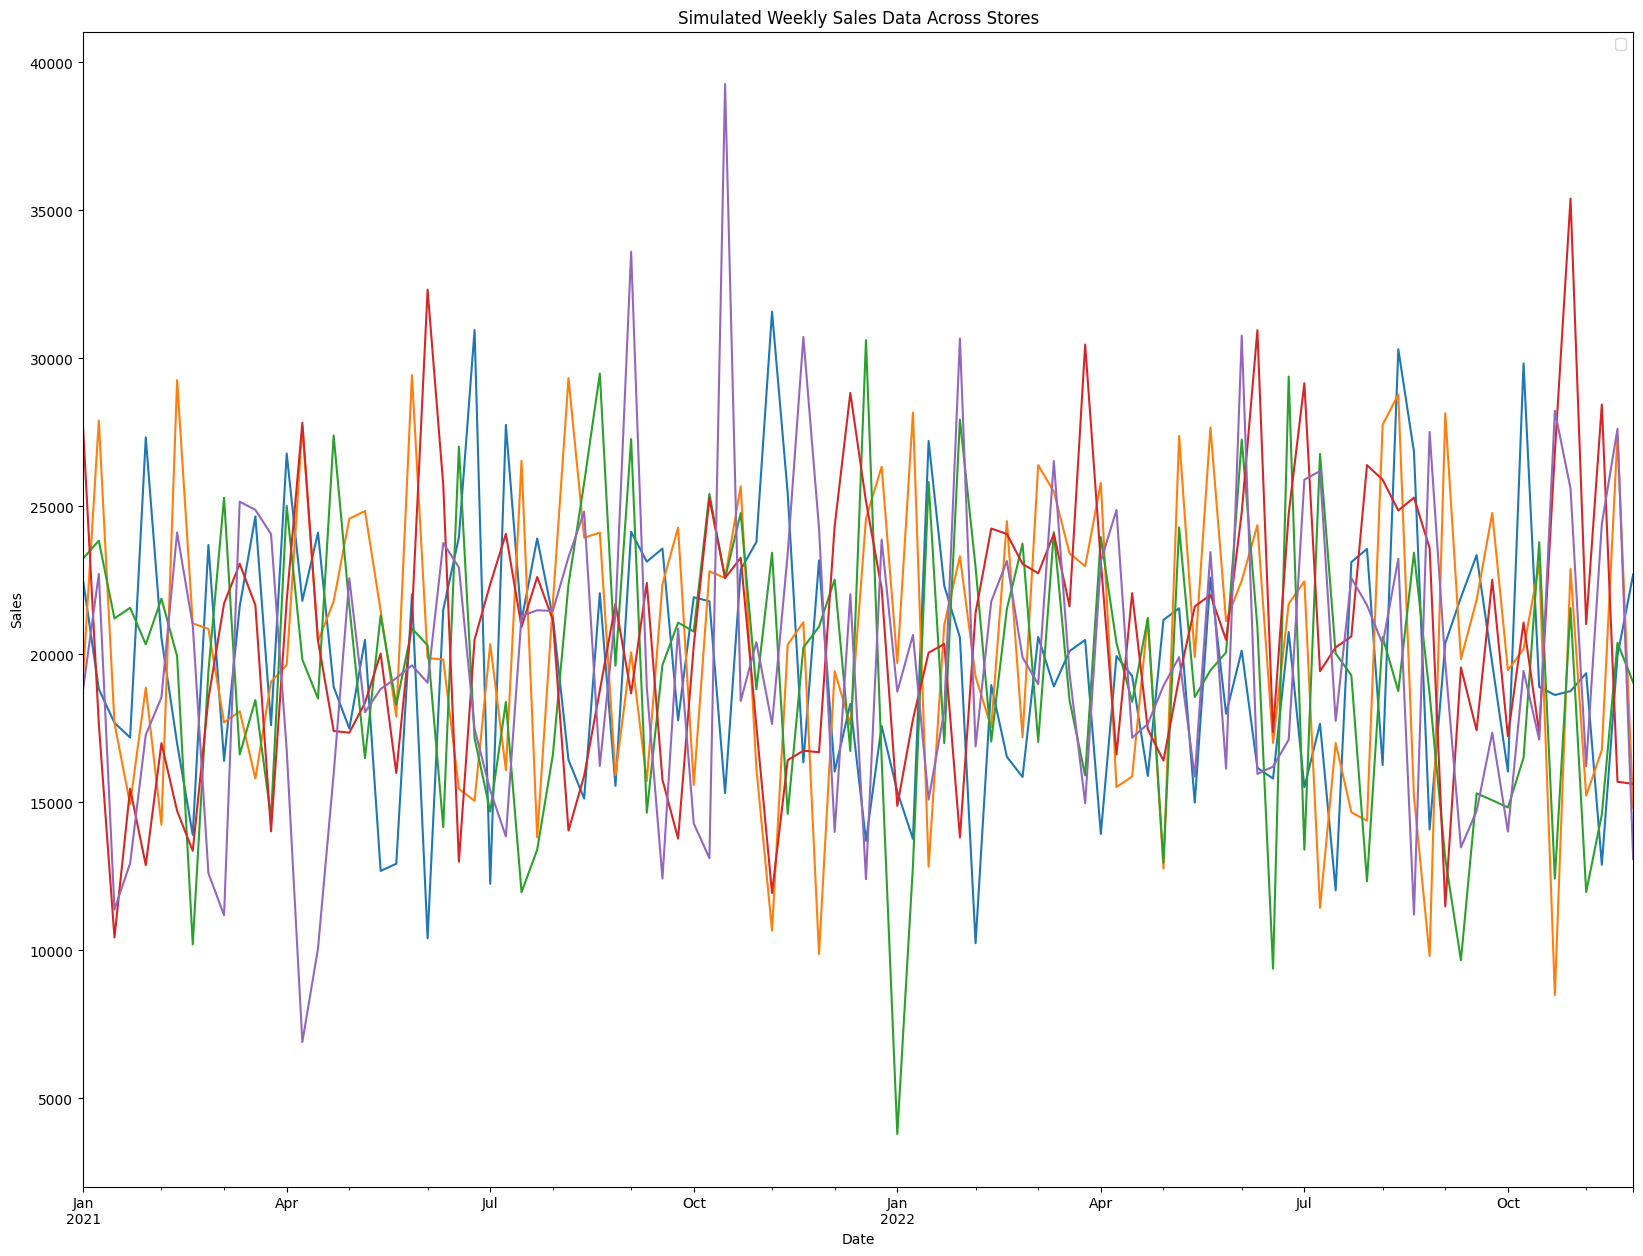

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Define parameters
n_dates = 100  # number of dates
n_stores = 5   # number of stores

# Create date range
dates = pd.date_range(start='2021-01-01', periods=n_dates, freq='W')

# Simulate weekly sales data
data = np.random.normal(loc=20000, scale=5000, size=(n_dates, n_stores))

# Create a DataFrame
sales_data = pd.DataFrame(data, index=dates, columns=[f'Store_{i+1}' for i in range(n_stores)])

# Pivot data (in this case, it's already in the desired form, but let's format it as per your original question)
sales_data = sales_data.stack().reset_index()
sales_data.columns = ['Date', 'Store', 'Weekly_Sales']

# Create pivot table similar to the one you'd have after reading from a CSV
pivot_table = sales_data.pivot_table(index='Date', columns='Store', values='Weekly_Sales')

# Plotting the data
ax = pivot_table.plot(figsize=(20, 15))
ax.legend([])
ax.set_ylabel('Sales')
plt.title('Simulated Weekly Sales Data Across Stores')
plt.show()


In [59]:
sales_data

,Date,Store,Weekly_Sales
0,2021-01-03,Store_1,22483.570765
1,2021-01-03,Store_2,19308.678494
2,2021-01-03,Store_3,23238.442691
3,2021-01-03,Store_4,27615.149282
4,2021-01-03,Store_5,18829.233126
...,...,...,...
495,2022-11-27,Store_1,22694.550218
496,2022-11-27,Store_2,14813.769228
497,2022-11-27,Store_3,19048.306610
498,2022-11-27,Store_4,15621.908733


In [66]:
data = sales_data.pivot_table(index = 'Date', columns = 'Store',
values = 'Weekly_Sales')

In [67]:
data

Store,Store_1,Store_2,Store_3,Store_4,Store_5
Date,,,,,
2021-01-03,22483.570765,19308.678494,23238.442691,27615.149282,18829.233126
2021-01-10,18829.315215,27896.064078,23837.173646,17652.628070,22712.800218
2021-01-17,17682.911536,17671.351232,21209.811358,10433.598777,11375.410837
2021-01-24,17188.562354,14935.844398,21571.236663,15459.879622,12938.481493
2021-01-31,27328.243845,18871.118498,20337.641023,12876.259069,17278.086377
...,...,...,...,...,...
2022-10-30,18754.819802,22882.784815,21556.250773,35394.404042,25597.874557
2022-11-06,19360.412043,15222.297797,11967.768399,21017.318179,16218.246274
2022-11-13,12888.731452,16767.135579,14592.259982,28435.708175,24408.198785


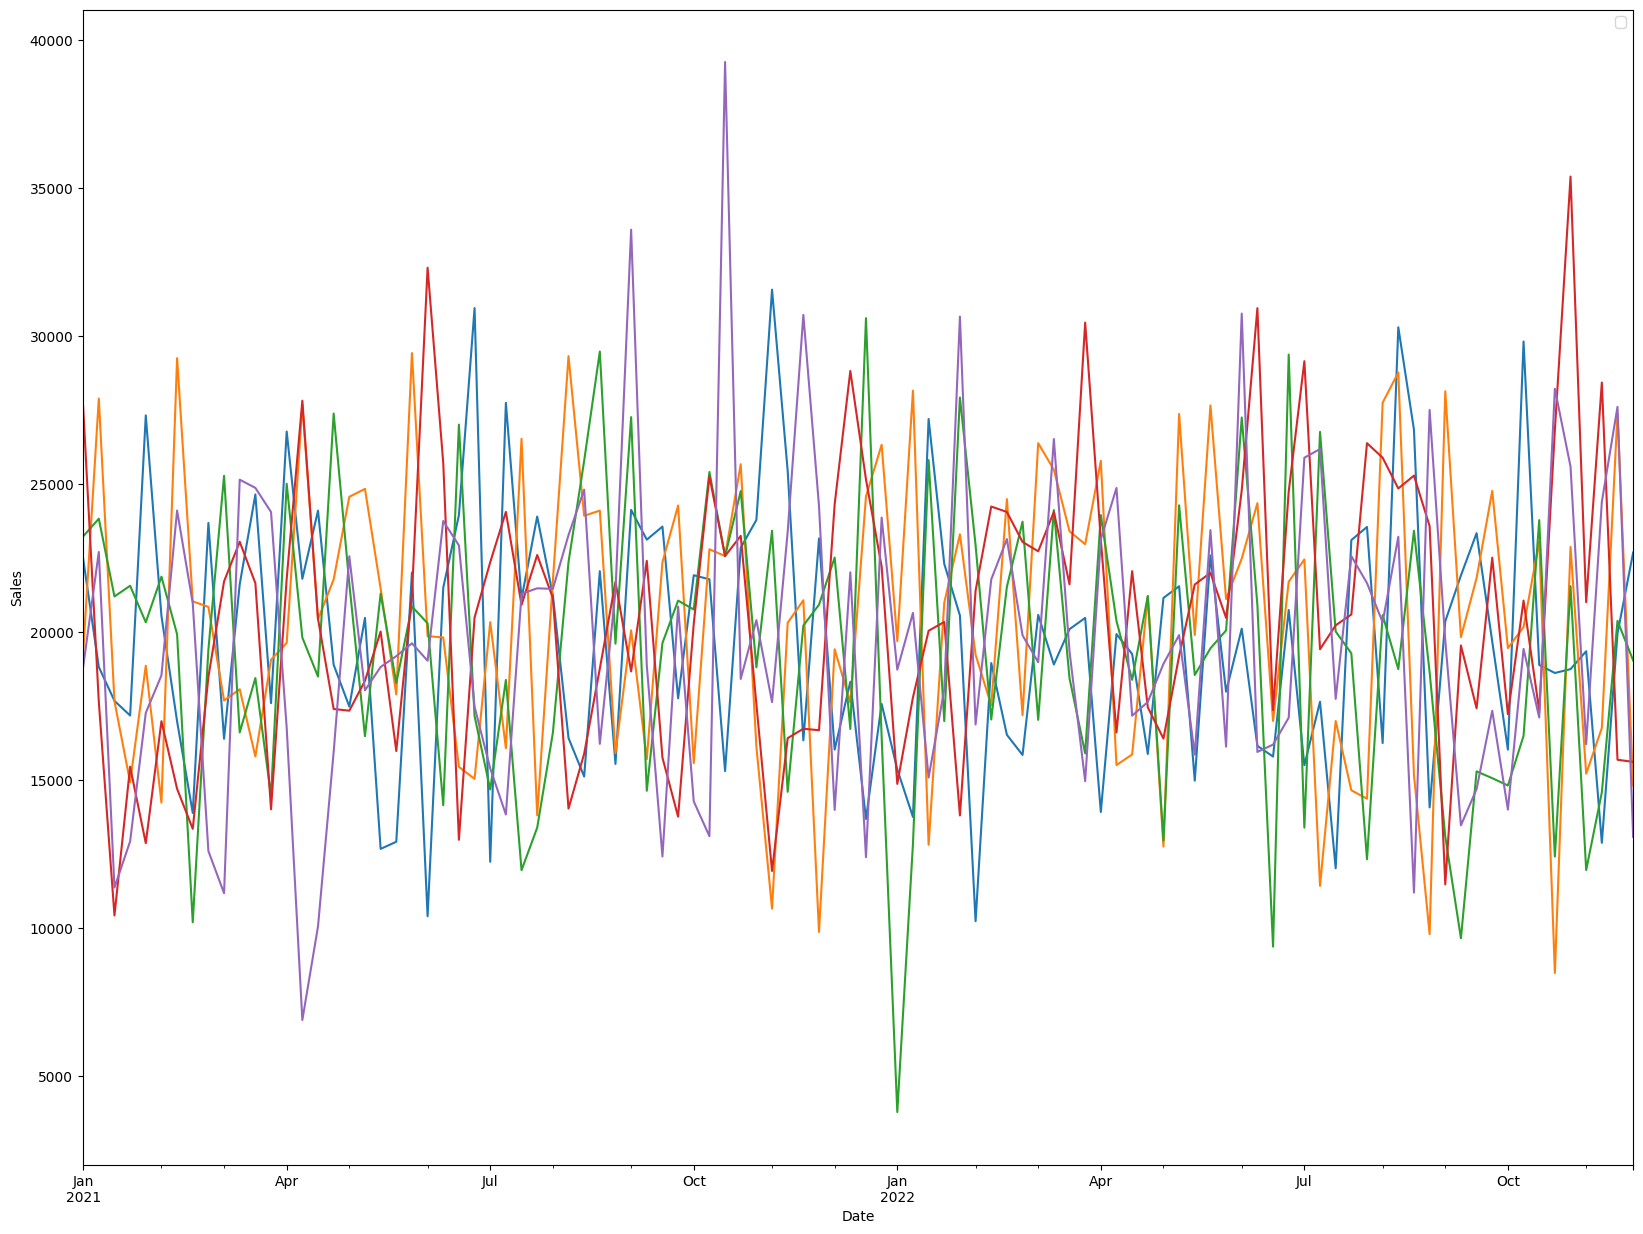

In [68]:
ax = data.plot(figsize=(20,15))
ax.legend([])
ax.set_ylabel('Sales')
plt.show()

In [69]:
train = data.iloc[:-10, :]
train

Store,Store_1,Store_2,Store_3,Store_4,Store_5
Date,,,,,
2021-01-03,22483.570765,19308.678494,23238.442691,27615.149282,18829.233126
2021-01-10,18829.315215,27896.064078,23837.173646,17652.628070,22712.800218
2021-01-17,17682.911536,17671.351232,21209.811358,10433.598777,11375.410837
2021-01-24,17188.562354,14935.844398,21571.236663,15459.879622,12938.481493
2021-01-31,27328.243845,18871.118498,20337.641023,12876.259069,17278.086377
...,...,...,...,...,...
2022-08-21,26843.157788,15175.382697,23430.257300,25292.122434,11206.302568
2022-08-28,14083.707437,9803.839111,18652.965828,23587.711279,27511.785260
2022-09-04,20370.473902,28143.077728,13099.492709,11483.087803,19722.261506


In [70]:
test = data.iloc[-10:, :]
test

Store,Store_1,Store_2,Store_3,Store_4,Store_5
Date,,,,,
2022-09-25,19686.604514,24775.711603,15071.369768,22520.232578,17348.711908
2022-10-02,16035.635839,19464.848200,14823.788388,17231.753473,14010.610537
2022-10-09,29823.625665,20176.317760,16501.372460,21069.899554,19438.359752
2022-10-16,18895.152002,23070.833500,23787.538550,17347.494262,17120.908797
2022-10-23,18624.741514,8490.394176,12424.044689,26834.371337,28224.838568
2022-10-30,18754.819802,22882.784815,21556.250773,35394.404042,25597.874557
2022-11-06,19360.412043,15222.297797,11967.768399,21017.318179,16218.246274
2022-11-13,12888.731452,16767.135579,14592.259982,28435.708175,24408.198785
2022-11-20,19960.136793,27399.720694,20386.841538,15693.578993,27615.620386


In [87]:
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.api import VAR

model = VAR(train)
results = model.fit(maxlags=1)
lag_order = results.k_ar
fcst = results.forecast(train.values[-lag_order:], 10)
model_accuracy = 1 - mean_absolute_percentage_error(test, fcst)
print(model_accuracy)

0.7658092554453242


/home/ab000840/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [88]:
fcst

array([[20264.83764919, 20382.23635664, 19743.76110575, 19000.6011807 ,
        17970.15222173],
       [19896.85398814, 20386.06703277, 19721.45920731, 19872.78367547,
        19362.31550197],
       [19837.87246927, 20460.65260001, 19766.57117565, 20162.57925684,
        19621.38362488],
       [19800.73628911, 20483.71217052, 19770.44618032, 20268.15451495,
        19695.57390821],
       [19789.48857589, 20494.94625546, 19772.28493117, 20304.2458875 ,
        19723.69369465],
       [19785.22385501, 20498.3191028 , 19772.90864828, 20316.8240841 ,
        19732.79924519],
       [19783.80020577, 20499.58279496, 19773.11916769, 20321.16929312,
        19736.07425345],
       [19783.29849024, 20500.00430204, 19773.1939803 , 20322.67589149,
        19737.18798754],
       [19783.12608374, 20500.15290769, 19773.21951588, 20323.19745839,
        19737.57719216],
       [19783.06615853, 20500.20395658, 19773.22842904, 20323.37814156,
        19737.71143592]])

In [89]:
results

In [90]:
results.params

,Store_1,Store_2,Store_3,Store_4,Store_5
const,26722.990558,22244.971212,21015.240618,9541.651239,17616.118353
L1.Store_1,-0.040584,-0.045657,-0.028332,0.045301,-0.124953
L1.Store_2,-0.097707,-0.069545,-0.007726,0.028957,-0.115968
L1.Store_3,-0.113615,-0.068154,-0.046173,0.110799,0.100685
L1.Store_4,-0.101655,0.142037,-0.011024,0.342139,0.241380
L1.Store_5,0.009041,-0.048378,0.031104,0.007483,0.003771


In [75]:
coefficients = results.params

In [77]:
print(coefficients.columns)

Index(['Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5'], dtype='object')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


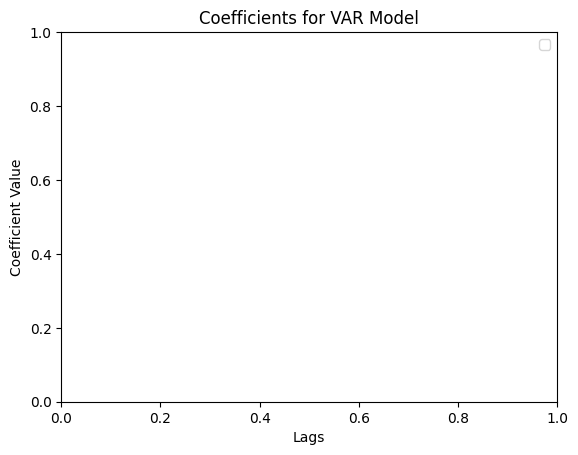

In [76]:
# Loop through each lag and plot its coefficient
for col in coefficients.columns:
    if 'L1' in col:  # Example: Adjust to select the correct lag variables
        plt.plot(coefficients.index, coefficients[col], label=col)

plt.title('Coefficients for VAR Model')
plt.xlabel('Lags')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

In [78]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Apr, 2024
Time:                     14:06:47
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    86.8954
Nobs:                     88.0000    HQIC:                   85.9708
Log likelihood:          -4324.60    FPE:                1.17110e+37
AIC:                      85.3470    Det(Omega_mle):     6.49876e+36
--------------------------------------------------------------------
Results for equation Store_1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const          23978.674255      7150.183565            3.354           0.001
L1.Store_1        -0.032733         0.116068           -0.282           0.778
L1.Store_2        -0.105718         0.107332           -0.985         